# RANSAC PART 1

## 0. import

In [1]:
import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt
from plot_inlier_matches import plot_inlier_matches
from tqdm import tqdm

In [2]:
def cv_show_image(names, imgs):
    for name, img in zip(names, imgs):
        print(name, img.shape)
        cv2.namedWindow(name, cv2.WINDOW_NORMAL)
        cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


## 1. load image and convert to grayscale

In [3]:
img_left = cv2.imread('img/parliament-left.jpg')
img_right = cv2.imread('img/parliament-right.jpg')
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

cv_show_image(['left', 'right'], [img_left, img_right])

left (2575, 2556)
right (2400, 2266)


## 2. Detect keypoints and extract descriptors

In [4]:
sift = cv2.SIFT_create() # descriptor: 128-dim vector, 
kp_left, des_left = sift.detectAndCompute(img_left, None)
kp_right, des_right = sift.detectAndCompute(img_right, None)

kp_left_img = cv2.drawKeypoints(img_left, kp_left, None)
kp_right_img = cv2.drawKeypoints(img_right, kp_right, None)

cv_show_image(['left', 'right'], [kp_left_img, kp_right_img])

left (2575, 2556, 3)
right (2400, 2266, 3)


## 3. Match features

In [5]:
# compute the distance between each pair of the two collections of inputs
print(des_left.shape, des_right.shape)

distances = scipy.spatial.distance.cdist(des_left, des_right, 'sqeuclidean')
print(distances.shape)

(16538, 128) (17642, 128)
(16538, 17642)


## 4. Prune features

In [15]:
# distances = np.array([[5, 1, 7], [8, 2, 6], [3, 9, 4]])
# print(distances.flatten())
# print(np.array([i for i in range(9)]))

# for n in range(5):
#     indices = distances.argpartition(n, axis=None)  # n numbers to the left are the smallest
#     print(indices)



[5 1 7 8 2 6 3 9 4]
[0 1 2 3 4 5 6 7 8]
[1 0 2 3 4 5 6 7 8]
[1 4 2 3 0 5 6 7 8]
[1 4 6 3 0 5 2 7 8]
[1 4 6 8 3 5 2 7 0]
[1 4 6 8 0 5 2 7 3]


In [6]:
# find the x,y index of the n smallest distances
n = 300
indices = distances.argpartition(n, axis=None)[:n] # n smallest indices (x-1)*width+y
x_indices, y_indices = np.unravel_index(indices, distances.shape)
print(x_indices.shape, y_indices.shape)

(300,) (300,)


In [7]:
filtered_des_left = des_left[x_indices]
filtered_des_right = des_right[y_indices]
filtered_kp_left = [kp_left[i] for i in x_indices]
filtered_kp_right = [kp_right[i] for i in y_indices]

filtered_kp_left_img = cv2.drawKeypoints(img_left, filtered_kp_left, None)
filtered_kp_right_img = cv2.drawKeypoints(img_right, filtered_kp_right, None)

# cv_show_image(['left', 'right'], [filtered_kp_left_img, filtered_kp_right_img])

In [8]:
# create an image called expand_right that is the same width and same height as img_left, put img_right in the left top corner
expand_right = np.zeros((img_left.shape[0], img_left.shape[1]), dtype=np.uint8)
expand_right[:img_right.shape[0], :img_right.shape[1]] = img_right

# cv_show_image(['expand_right'], [expand_right])

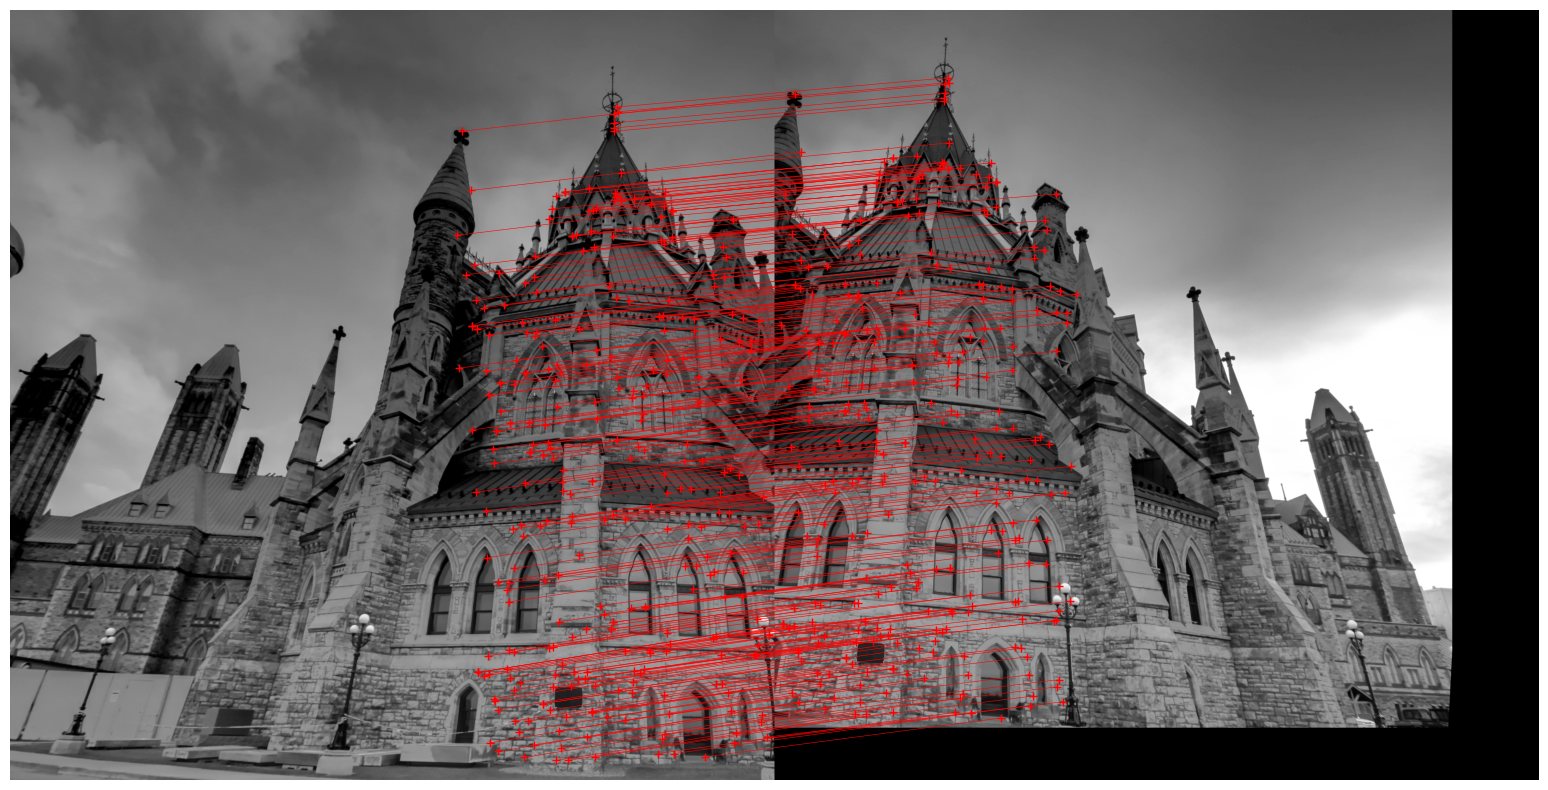

In [9]:
matches = np.array([[filtered_kp_left[i].pt[0],filtered_kp_left[i].pt[1],filtered_kp_right[i].pt[0],filtered_kp_right[i].pt[1]] for i in range(n)])
matches = matches.astype(int)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img_left, expand_right, matches)

## 5. Robust transformation estimation 
## 6. Compute optimal transformation

In [10]:
num_best_inliers = 0
best_inliers = None
best_H = None

iters = 1000
threshold = 1
match_num = 4

for i in tqdm(range(iters)):
    # randomly select matches
    idx = np.random.choice(n, match_num, replace=False)
    src = np.array([[matches[i][0], matches[i][1]] for i in idx])
    dst = np.array([[matches[i][2]+2000, matches[i][3]] for i in idx])
    # compute the affine transformation
    H, _ = cv2.estimateAffine2D(src, dst)
    # extract all the matches except the 4 inliers
    src_test = np.array([[matches[i][0], matches[i][1]] for i in range(n) if i not in idx])
    dst_test = np.array([[matches[i][2]+2000, matches[i][3]] for i in range(n) if i not in idx])
    # transform the points
    src_test = np.concatenate([src_test, np.ones((n-match_num, 1))], axis=1)
    dst_test_ = np.dot(H, src_test.T).T
    # compute the distance between the transformed points and the dst
    dist = np.sqrt(np.sum((dst_test - dst_test_[:,:2])**2, axis=1))
    # count the number of inliers
    num_inliers = np.sum(dist < threshold)
    # update the best number of inliers and the best homography
    if num_inliers > num_best_inliers:
        num_best_inliers = num_inliers
        best_H = H
        best_inliers = np.where(dist < threshold)[0]
        print(f"i: {i}, num_best_inliers: {num_best_inliers}/{n-match_num}")
    if num_best_inliers == n-match_num:
        print("break, cannot find better inliers")
        break

  7%|▋         | 68/1000 [00:00<00:01, 673.50it/s]

i: 0, num_best_inliers: 255/296
i: 1, num_best_inliers: 264/296
i: 3, num_best_inliers: 282/296
i: 12, num_best_inliers: 289/296


 33%|███▎      | 332/1000 [00:00<00:01, 637.80it/s]

i: 249, num_best_inliers: 291/296


100%|██████████| 1000/1000 [00:01<00:00, 633.47it/s]


In [12]:
print(best_H)

[[ 9.78217075e-01 -5.11839960e-02  6.12507596e+02]
 [ 5.10153113e-02  9.78375683e-01 -1.94450042e+02]]


## 7. Create panorama

In [12]:
img1 = cv2.imread('img/parliament-left.jpg')
img2 = cv2.imread('img/parliament-right.jpg')

best_H = np.vstack([best_H, [0, 0, 1]]) if best_H.shape[0] == 2 else best_H

# Get the dimensions of the images
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]

# Warp img1 using the transformation matrix H
img1_warped = cv2.warpPerspective(img1, best_H, (width2 + width1, max(height1, height2)))

# Copy img2 to the panorama image
result_image = img1_warped.copy()

# Overlay img2 onto the panorama image
result_image[0:height2, 2000:width2+2000] = img2

# Display the result or save it to a file
cv_show_image(['result_image'], [result_image])

result_image (2575, 4822, 3)


# PART 2

In [13]:
def compute_A_partial(src, dst):
    x,y,z = src[0], src[1], 1
    x_t,y_t,z_t = dst[0], dst[1], 1
    A_partial = np.array([[-x, -y, -1, 0, 0, 0, x*x_t, y*x_t, x_t],
                            [0, 0, 0, -x, -y, -1, x*y_t, y*y_t, y_t]])
    return A_partial

def compute_A(src, dst):
    A = np.zeros((2*len(src), 9))
    for i in range(len(src)):
        A[2*i:2*i+2] = compute_A_partial(src[i], dst[i])
    return A

def compute_Homography(src, dst):
    A = compute_A(src=src, dst=dst)
    U, S, V = np.linalg.svd(A)
    H = V[-1].reshape(3,3)
    return H

num_best_inliers = 0
best_inliers = None
best_H = None

iters = 1000
threshold = 10
match_num = 4

for i in tqdm(range(iters)):
    # randomly select matches
    idx = np.random.choice(n, match_num, replace=False)
    src = np.array([[matches[i][0], matches[i][1]] for i in idx])
    dst = np.array([[matches[i][2]+2000, matches[i][3]] for i in idx])
    # compute the homography
    H = compute_Homography(src, dst)
    # extract all the matches except the 4 inliers
    src_test = np.array([[matches[i][0], matches[i][1]] for i in range(n) if i not in idx])
    dst_test = np.array([[matches[i][2]+2000, matches[i][3]] for i in range(n) if i not in idx])
    # transform the points
    src_test = np.concatenate([src_test, np.ones((n-match_num, 1))], axis=1)
    dst_test_ = np.dot(H, src_test.T).T
    dst_test_ = dst_test_ / dst_test_[:, 2, None]
    # compute the distance between the transformed points and the dst
    dist = np.sqrt(np.sum((dst_test - dst_test_[:,:2])**2, axis=1))
    # count the number of inliers
    num_inliers = np.sum(dist < threshold)
    # update the best number of inliers and the best homography
    if num_inliers > num_best_inliers:
        num_best_inliers = num_inliers
        best_H = H
        best_inliers = np.where(dist < threshold)[0]
        print(f"i: {i}, num_best_inliers: {num_best_inliers}/{n-match_num}")
    if num_best_inliers == n-match_num:
        print("break, cannot find better inliers")
        break

  0%|          | 1/1000 [00:00<00:07, 132.91it/s]

i: 0, num_best_inliers: 206/296
i: 1, num_best_inliers: 296/296
break, cannot find better inliers


In [14]:
img1 = cv2.imread('img/parliament-left.jpg')
img2 = cv2.imread('img/parliament-right.jpg')

best_H = np.vstack([best_H, [0, 0, 1]]) if best_H.shape[0] == 2 else best_H

# Get the dimensions of the images
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]

# Warp img1 using the transformation matrix H
img1_warped = cv2.warpPerspective(img1, best_H, (width2 + width1, max(height1, height2)))

# Copy img2 to the panorama image
result_image = img1_warped.copy()

# Overlay img2 onto the panorama image
result_image[0:height2, 2000:width2+2000] = img2

# Display the result or save it to a file
cv_show_image(['result_image'], [result_image])

result_image (2575, 4822, 3)
